# Recurrent Neural Networks

Recurrent Neural Networks are all about time series and predicting when it's time to act. For example, when to buy or sell on the stock market, or when to steer clear of danger in the case of an autonomous vehicle. 

This is also useful for natural language processing. For an input they could take sentences, audio files, or documents as an input and process a translation or text-to-speech. 

For this chapter, we'll use backpropagation-over-time to train an RNN then use them to forecast a time series. 

## The Two Main Difficulties RNNs Face:
- Unstable Gradients - Which can be allieviated using techniques such as recurrent dropout and recurrent layer normalization
- A very limited short term memory. Extensible via LSTM and GRU cells

Remember, RNNs aren't the only type of neural networks capable of handling time series. More on this later. 

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

First let's make a function to generate a time series of data. The function below creates as many time series as requested via the batch_size argument, evenly spaces their intervals out, and returns a numpy array of shape *[batch_size, time steps, 1]*, where each series is the sum  of two sine waves BUT random frequencies and phases (plus a bit of noise).

In [72]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 4 arrays of random numbers
    time= np.linspace(0, 1, n_steps) # 1D array of evenly spaced numbers over a specified interval
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # 1D array of sine values
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # 1D array of sine values
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # 2D array of random numbers
    return series[..., np.newaxis].astype(np.float32) # 3D array of random numbers

In [73]:
#let's plot the first instance's series:
def plot_series(series, y=None, y_pred=None, title="title", x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    plt.title(title, fontsize=16)

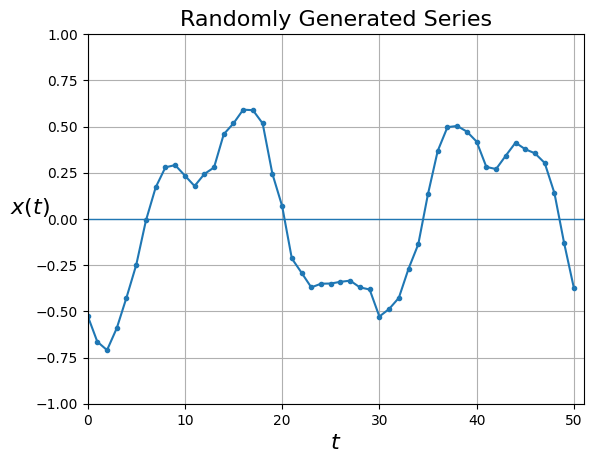

In [91]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1) # 3D array of random numbers
plot_series(series[0, :, 0], title="Randomly Generated Series")

As pure usual in Data Science, time to split our data into training, testing, and validation sets. 

In [92]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # 2D array of random numbers
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1] # 2D array of random numbers
X_test, y_test = series[9000:, :n_steps], series[9000:, -1] # 2D array of random numbers

In [93]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((7000, 50, 1), (7000, 1), (2000, 50, 1), (2000, 1), (1000, 50, 1), (1000, 1))

Best to have some baseline metrics before continuing, or we could end up thinking our model works great when in fact its performing worse than basic models. 

**Naive forecasting**, whereas we ask the model to predict the last value is one such simple approach.

In [94]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020582518

Another baseline approach is with a fully connected network. So let's use  a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series. 

In [95]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
model.evaluate(X_valid, y_valid)


Epoch 1/20


219/219 [==============================] - 1s 1ms/step - loss: 0.1074 - val_loss: 0.0469
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0193
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0118
Epoch 4/20
219/219 [==============================] - 0s 972us/step - loss: 0.0098 - val_loss: 0.0090
Epoch 5/20
219/219 [==============================] - 0s 997us/step - loss: 0.0081 - val_loss: 0.0079
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 7/20
219/219 [==============================] - 0s 997us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 9/20
219/219 [==============================] - 0s 993us/step - loss: 0.0057 - val_loss: 0.0056
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0053
Ep

0.003776478348299861

A MSE of 0.0046 is pretty good. Can RNNs beat that?

Time to create an RNN version of the model. 

In [96]:
modelRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [80]:
modelRNN.compile(loss="mse", optimizer="adam")
historyRNN = modelRNN.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
modelRNN.evaluate(X_valid, y_valid)


Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.0156 - val_loss: 0.0126
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113

0.011297508142888546

This isn't exactly better than the Naive Approach so let's try adding some layers for a *Deep RNN.*

In [97]:
modelRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20,  return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [98]:
modelRNN.compile(loss="mse", optimizer="adam")
historyRNN = modelRNN.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
modelRNN.evaluate(X_valid, y_valid)


Epoch 1/20


219/219 [==============================] - 4s 12ms/step - loss: 0.0265 - val_loss: 0.0063
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0028 - val_loss: 0.0030


0.003113949205726385

This beats the simple linear model!

# Forecasting Several Time Steps Ahead

We've predicted one step ahead at a time, but we can just as easily predict further by changing the target. 

First option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had acctually occured), and use the model against to predict the following value, and so on...

In [101]:
#Forecasting Several Steps Ahead

series=generate_time_series(1, n_steps+10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 16ms/step


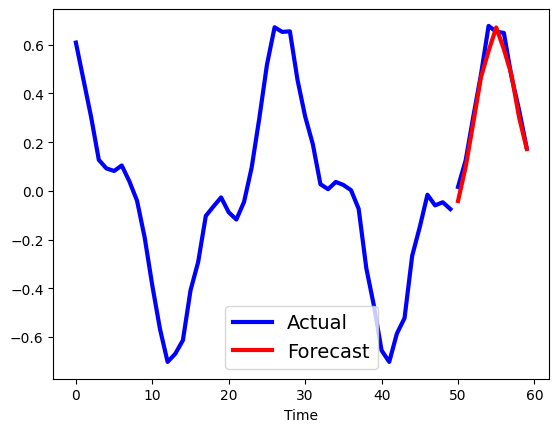

In [103]:
#Graph the results for the actual and forecasted values

plt.plot(np.arange(n_steps), X_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "b-", linewidth=3)
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "r-", linewidth=3, label="Forecast")
plt.xlabel("Time")
plt.legend(fontsize=14)
plt.show()


In [85]:
#score the model


Second option is to train an RNN to predict the next 10 values at once using a sequence-to-vector model.

In [104]:
seriesRNN = generate_time_series(10000, n_steps + 10)
X_train, Y_train = seriesRNN[:7000, :n_steps], seriesRNN[:7000, -10:, 0]
X_valid, Y_valid = seriesRNN[7000:9000, :n_steps], seriesRNN[7000:9000, -10:, 0]
X_test, Y_test = seriesRNN[9000:, :n_steps], seriesRNN[9000:, -10:, 0]

We just need the dense output layer to have 10 units instead of one. 

In [109]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [110]:
#now easily predict the next 10 values
Y_pred = model.predict(X_new)

1/1 [==============================] - 0s 176ms/step


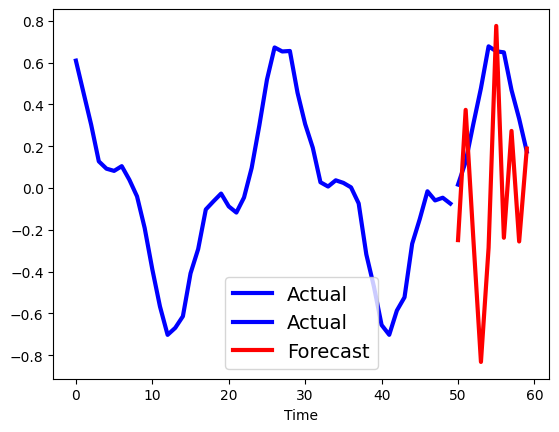

In [112]:
#graph the results for the actual and forecasted values
import matplotlib.pyplot as plt
plt.plot(np.arange(n_steps), X_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :], "r-", linewidth=3, label="Forecast")
plt.xlabel("Time")
plt.legend(fontsize=14)
plt.show()


Looks like we may have a gradient problem above. [TODO- More on exploding and vanishing gradients]

# Fighting the Unstable Gradient Problem
Mindful, RNNs aren't used that often. The more you unroll a gradient, the harder it is to train. This is known as the *vanishing/exploding gradient problem.*

Many tricks to aleviate the unstable gradient problem such as a non-satuarating activation function (e.g. ReLU) may not help. If anything, they might hurt, hence why TanH is the default. 

*Layer Normalization* often works better with RNNs. Instead of normalizing accross the batch dimension, it normalizes across the feature dimension. 

In [90]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

# TODO - Explaination of LNSimpleRNNCell

In [113]:
modeLNN= keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [114]:
#now easily predict the next 10 values
Y_pred = modelLNN.predict(X_new)


1/1 [==============================] - 0s 272ms/step


ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

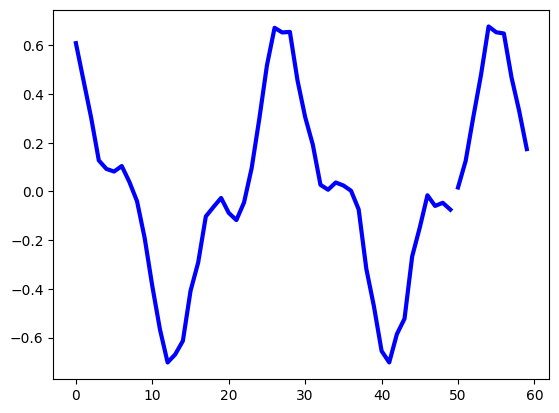

In [126]:
#graph the results
plt.plot(np.arange(n_steps), X_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "r-", linewidth=3, label="Forecast") #TODO Make the dimensions work
plt.xlabel("Time")
plt.legend(fontsize=14)
plt.show()
